<a href="https://colab.research.google.com/github/nicolasquant/Mercado_Financeiro/blob/main/Markowitz_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No código a seguir, desenvolv

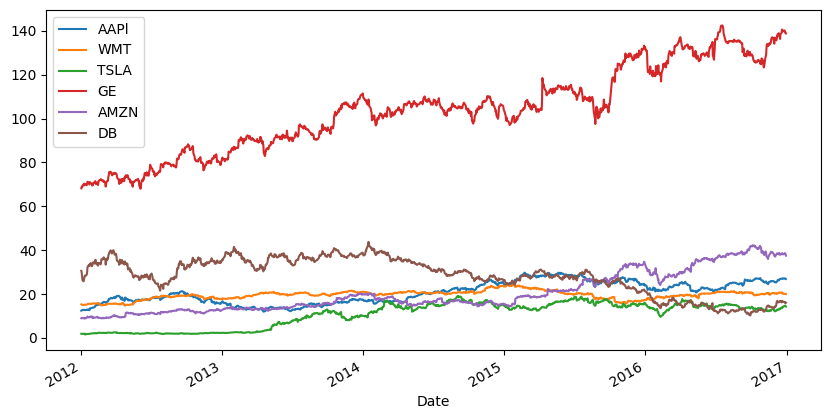

O retorno anual de cada ação é de  AAPl    0.154803
WMT     0.053214
TSLA    0.406862
GE      0.142554
AMZN    0.287153
DB     -0.128913
dtype: float64
A covariancia de cada ação é de            AAPl       WMT      TSLA        GE      AMZN        DB
AAPl  0.068351  0.008142  0.025434  0.014196  0.019009  0.024571
WMT   0.008142  0.028017  0.010265  0.009221  0.008545  0.013247
TSLA  0.025434  0.010265  0.252700  0.019334  0.041774  0.039047
GE    0.014196  0.009221  0.019334  0.032647  0.018026  0.031347
AMZN  0.019009  0.008545  0.041774  0.018026  0.094476  0.031574
DB    0.024571  0.013247  0.039047  0.031347  0.031574  0.139114


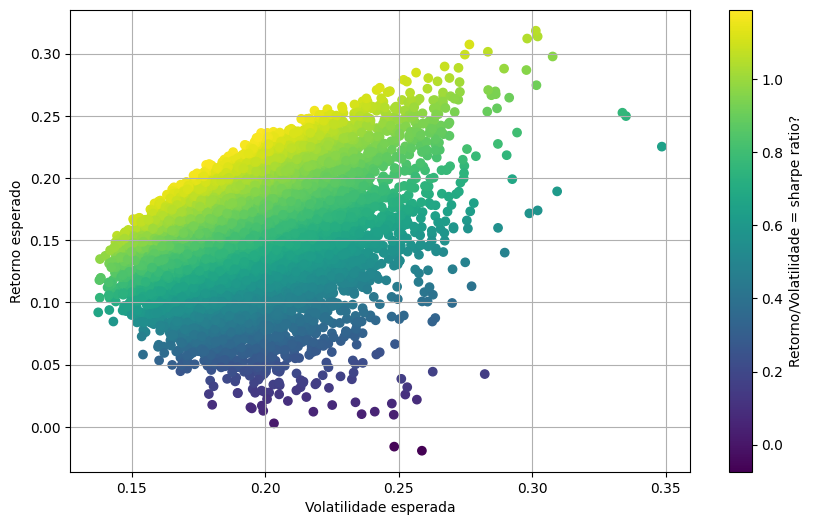

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import scipy.optimize as optimization

# na média, possuímos 252 dias de trades no ano (dias em que o mercado está aberto)
NUM_TRADING_DAYS = 252
# irá geral 10000 grupos de pesos aleatórios e diferentes para cada uma das ações
NUM_PORTFOLIOS = 10000

# stocks que iremos usar
stocks = ['AAPl', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

#Dados historicos - define a data de análise inicial e final

start_date = '2012-01-01'
end_date = '2017-01-01'

def download_data():
    #nome das stocks (key) - preços das ações
    stock_data = {}

    for stock in stocks:
        # vamos pegar só os preços de fechamento do dia
        ticker = yf.Ticker(stock) # o que é esse ticker de fato?
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close'] # 'Close' pois quremos apenas os preços de fechamento do dia
    return pd.DataFrame(stock_data)


def show_data(data_frame):
    data_frame.plot(figsize=(10,5))
    plt.show()

def calculate_return(data): # aqui, usaremos a o retorno do lucro em forma de log, pois é mais tradicional
    log_return = np.log(data / data.shift(1)) # data.shift(1) está pegando um elemento a frente do elemento pego em data
    return log_return[0:]

def show_statistics(returns):
  # ao inves de usamos o lucro diário, costumamos usar o lucro anual
  # com isso, calcularemos a média dos dias e multiplicaremos pelo número de dias de trade, definidos acima
  print('O retorno anual de cada ação é de ', returns.mean()*NUM_TRADING_DAYS)
  print('A covariancia de cada ação é de ', returns.cov()*NUM_TRADING_DAYS) # calculando a covariancia média anual - essa nos retorna a matriz de covariancia, explicada no curso

def show_mean_variance(returns, weights):
  portfolio_return = np.sum(returns.mean()*weights)*NUM_TRADING_DAYS
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*NUM_TRADING_DAYS, weights)))

  print('valor experado do portfólio (média): ', portfolio_return)
  print('volatilidade do portfólio (desvio padrão): ', portfolio_volatility)

def generate_portfolios(returns): # aqui iremos gerar n portfolios aleatórios para julgar, nos baseando nas taxas de retorno e desvio padrão, qual o melhor portfolio a escolher
  # basicamente, iremos gerar 10000 diferentes portfólios, cada um com um valor percentual aleatório pra cada ação e com isso, veremos qual o portfolio mais otimizado
  portfolio_means = []
  portfolio_risk = []
  portfolio_weights = []

  for _ in range(NUM_PORTFOLIOS):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights) # w = w/np.sum(w) - estamos normalizando os peso, pois sabemos que a soma deles devem ser = 1
    portfolio_weights.append(weights)
    portfolio_means.append(np.sum(returns.mean()*weights)*NUM_TRADING_DAYS)
    portfolio_risk.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*NUM_TRADING_DAYS, weights))))

  return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risk)

def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10,6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Volatilidade esperada')
    plt.ylabel('Retorno esperado')
    plt.colorbar(label='Retorno/Volatilidade = sharpe ratio?')
    plt.show()

def statistics(weights, inputs): # estamos criando uma cópia da def show_statistics, mas agora, com o intuito de jogar essas estatisticas no cálculo da sharpe ratio
  portfolio_return = np.sum(inputs.mean()*weights)*NUM_TRADING_DAYS
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(inputs.cov()*NUM_TRADING_DAYS, weights)))

  return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])


# note, scipy optmize pode achar o mínimo de uma dada função. COm isso, o máximo de uma função f(x) é igual ao mínimo de -f(x), por isso o sinal negativo do return
def min_function_sharpe(weights, returns):
    return statistics(weights, returns)[2] * -1 # estamos pegando apenas a sharpe ratio, definida na def 'statistics'

def optimize_portfolios(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # constraints será a cond de contorno que define que a soma de nossos pesos deve ser =1
    bounds = tuple((0,1) for _ in range(len(stocks)))

if __name__ == '__main__':
    dataset = download_data()
    # print(dataset)
    show_data(dataset)
    retorno_diario_logaritmo = calculate_return(dataset)
    # show_statistics(retorno_diario_logaritmo)
    show_statistics(retorno_diario_logaritmo)
    pweights, means, risks = generate_portfolios(retorno_diario_logaritmo)
    show_portfolios(means, risks)
